# Prenotazioni Hotel

## Sommario

### 1. Analisi Esplorativa dei Dati (AED)

Il Dataset Contiene i dati di due Hotel, uno di Città ed un Resort, ed è stato pubblicato ai fini di ricerca su Science Direct: https://www.sciencedirect.com/science/article/pii/S2352340918315191

I dettagli pubblicati su ScienceDirect ci forniscono alcune informazioni sugli Hotel, sappiamo ch entrambi sono situati in Portogallo a circa 300 Km l'uno dall'altro:
- Il Resort in Algarve
- Il Cittadino a Lisbona 

I dati contengono le informazioni relative a prenotazioni e arrivi dal 1° Luglio 2015 al 31 Agosto 2017

Cosa ci permettono di analizzare e capire questi dati?
- Da dove arrivano gli ospiti?
- Quanto pagano gli ospiti a notte?
- Come cambia il prezzo durante l'anno?
- Quali sono i mesi più "trafficati"?
- Quanto tempo restano gli ospiti?
- Prenotazioni per segmento di mercato
- Quante prenotazioni sono state cancellate?
- In quali mesi ci sono piu cancellazioni?

Queste sono le principali, ma in realta si puo rispondere a molte domande :-)

### 2. Predirre le Cancellazioni

Dal punto di vista di un Hotel o di un tour operator  poter prevedere le cancellazioni in maniera efficace può essere fondamentale per pianificare i turni del personale, le scorte alimentari e magari gestire con precisione l'Overbooking, vendendo piu camere di quelle esistenti ma potendo contare su una precisa previsione delle disponibilità.

### 3. Valutazione sull'importanza delle caratteristiche
Quali sono le caratteristiche(Features) piu importanti per predirre efficacemente le cancellazioni?  

In [3]:
# Setup

# Warnings

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Un pò di import generici:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import folium

# Importiamo scikit-learn:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

import eli5 # Per valutare le caratteristiche


import joblib # Per esportare il modello

# Configuro un pò l'aspetto grafico, cosi quando stamperemo i dati o disegneremo dei grafici saranno almeno presentabili :-)
sns.set(style="whitegrid")
pd.set_option("display.max_columns", 36)

# load data:
file_path = "../Data/HotelBooking.csv"
set_intero = pd.read_csv(file_path)

In [4]:
# Diamo una sbirciata alle prime righe del DataSet per essere sicuri che sia stato importato
set_intero.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [5]:
# Controlliamo se ci manca qualche dato
set_intero.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [6]:
# Diamo un'occhiata alla defizione dei dati
set_intero.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [7]:
# Vediamo anche quali valori unici possono esserci
# pd.unique(set_intero)

In [8]:
# Puliamo i dati mancanti:
# agent: se l'agenzia non è specificata presumibilmente significa che la prenotazione è stata fatta direttamente dall'ospite
# company: se la compagnia non è specificata siamo probabilmente in presenza di un Privato
# country: il paese di appartenenza
dati_mancanti_sostituzione = {"children:": 0,"country": "Unknown", "agent": 0, "company": 0}

# grazie al metodo info() sappiamo che:
#     - children, agent e company sono campi numerici, quindi 0 risulta essere un ottimo valore di default nel caso il dato risulti mancante
#     - country invece è una stringa, non conosciamo lo stato di appartenenza quindi "Unknown" è un buon valore di default
set_intero_pulito = set_intero.fillna(dati_mancanti_sostituzione)

# "meal" contiene il valore "Undefined" che sappiamo essere equiparabile al Self-Catering la cui sigla è SC.
set_intero_pulito["meal"].replace("Undefined", "SC", inplace=True)

# Alcune righe non hanno nessuna informazione sul numero di Ospiti, questo puo essere causato da un errore nel sistema o da un inserimento manuale
# Possiamo eliminare queste righe.
zero_ospiti = list(set_intero_pulito.loc[set_intero_pulito["adults"]
                   + set_intero_pulito["children"]
                   + set_intero_pulito["babies"]==0].index)
set_intero_pulito.drop(set_intero_pulito.index[zero_ospiti], inplace=True)

In [9]:
# Verifichiamo che ora sia tutto pulito
set_intero_pulito.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          4
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                         

In [10]:
# Adesso possiamo verificare le Dimensioni reali del nostro Dataset
set_intero_pulito.shape

(119210, 32)

## 1. Analisi Esplorativa dei Dati (AED)

In [11]:
# Ai fini di analisi dividiamo il dataset in base all'Hotel
# Scartiamo anche le prenotazioni cancellate
set_resort = set_intero_pulito.loc[(set_intero_pulito["hotel"] == "Resort Hotel") & (set_intero_pulito["is_canceled"] == 0)]
set_citta = set_intero_pulito.loc[(set_intero_pulito["hotel"] == "City Hotel") & (set_intero_pulito["is_canceled"] == 0)]

### Da dove arrivano gli ospiti?

In [12]:
# Prendiamo il numero di prenotazioni diviso per provenienza
prenotazioni_X_paese = pd.DataFrame(set_intero_pulito.loc[set_intero_pulito["is_canceled"] == 0]["country"].value_counts())

prenotazioni_X_paese.rename(columns={"country": "Numero di Ospiti"}, inplace=True)
ospiti_totali = prenotazioni_X_paese["Numero di Ospiti"].sum()
prenotazioni_X_paese["% Ospiti"] = round(prenotazioni_X_paese["Numero di Ospiti"] / ospiti_totali * 100, 2)
prenotazioni_X_paese["country"] = prenotazioni_X_paese.index


# Grafico a Torta
torta = px.pie(prenotazioni_X_paese,
             values="Numero di Ospiti",
             names="country",
             title="Paese di appartenenza",
             template="seaborn")
torta.update_traces(textposition="inside", textinfo="value+percent+label")
torta.show()

In [13]:
# e perche non su una mappa?
mappa_ospiti = px.choropleth(prenotazioni_X_paese,
                    locations=prenotazioni_X_paese.index,
                    color=prenotazioni_X_paese["% Ospiti"], 
                    hover_name=prenotazioni_X_paese.index, 
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="Paese di appartenenza")
mappa_ospiti.show()

### Quanto pagano gli ospiti a notte?
Ogni Hotel ha diversi tipi le camere e trattamenti, e vista la tipologia di struttura la stagione gioca un ruolo fondamentale nell'applicazione dei prezzi, quindi lavoreremo con 2 set distinti

Una nota sulla valuta, non è specificata da nessuna parte, quindi visto che siamo in Portogallo l'€uro è la scelta piu logica.

In [14]:
# Consideriamo adulti e bambini come ospiti paganti, gli Infant li escludiamo.
# E' logico pensare  che per alcune offerte anche l'infant sia considerato come pagante, ai fini statistici potremmo provare a considerarlo, ma questo è il tipo di generalizzazione che bisogna fare per mitigare il rischio di Overfitting in un modello di Machine Learning
set_resort["prezzo_X_persona"] = set_resort["adr"] / (set_resort["adults"] + set_resort["children"])
set_citta["prezzo_X_persona"] = set_citta["adr"] / (set_citta["adults"] + set_citta["children"])

In [15]:
print("""Di tutte le prenotazioni non cancellate, per ogni tipo di camera e trattamento il prezzo medio a persona è:
Resort: {:.2f} € a notte.
Citta: {:.2f} € a notte."""
      .format(set_resort["prezzo_X_persona"].mean(), set_citta["prezzo_X_persona"].mean()))

Di tutte le prenotazioni non cancellate, per ogni tipo di camera e trattamento il prezzo medio a persona è:
Resort: 47.49 € a notte.
Citta: 59.27 € a notte.


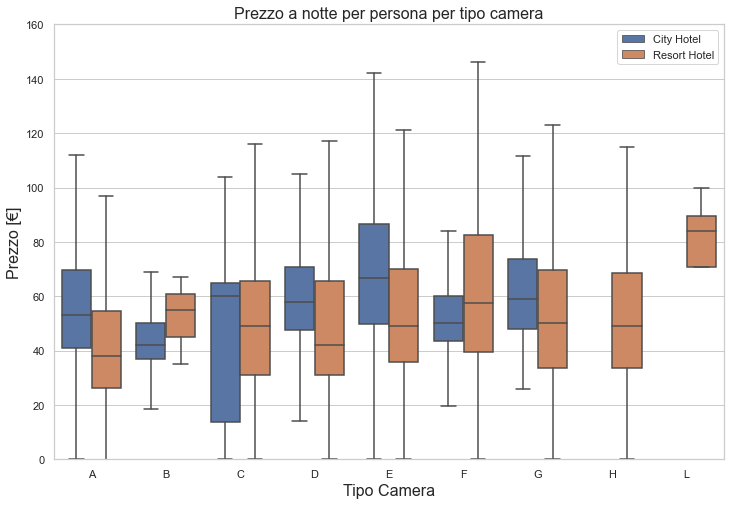

In [16]:
# normalize price per night (adr):
set_intero_pulito["prezzo_X_persona"] = set_intero_pulito["adr"] / (set_intero_pulito["adults"] + set_intero_pulito["children"])
set_intero_ospiti = set_intero_pulito.loc[set_intero_pulito["is_canceled"] == 0] # escludiamo le prenotazioni cancellate
prezzo_camere = set_intero_ospiti[["hotel", "reserved_room_type", "prezzo_X_persona"]].sort_values("reserved_room_type")

# boxplot:
plt.figure(figsize=(12, 8))
sns.boxplot(x="reserved_room_type",
            y="prezzo_X_persona",
            hue="hotel",
            data=prezzo_camere, 
            hue_order=["City Hotel", "Resort Hotel"],
            fliersize=0)
plt.title("Prezzo a notte per persona per tipo camera", fontsize=16)
plt.xlabel("Tipo Camera", fontsize=16)
plt.ylabel("Prezzo [€]", fontsize=16)
plt.legend(loc="upper right")
plt.ylim(0, 160)
plt.show()

Questa figura mostra il prezzo medio per camera, in base al tipo e la deviazione standard

Nota: siccome nel Dataset i tipi camere sono stati anonimizzati non c'è la certezza che la camera di tipo A del resort e la camera dell'hotel in citta siano effettivamente lo stesso tipo.

### Come cambia il prezzo durante l'anno?

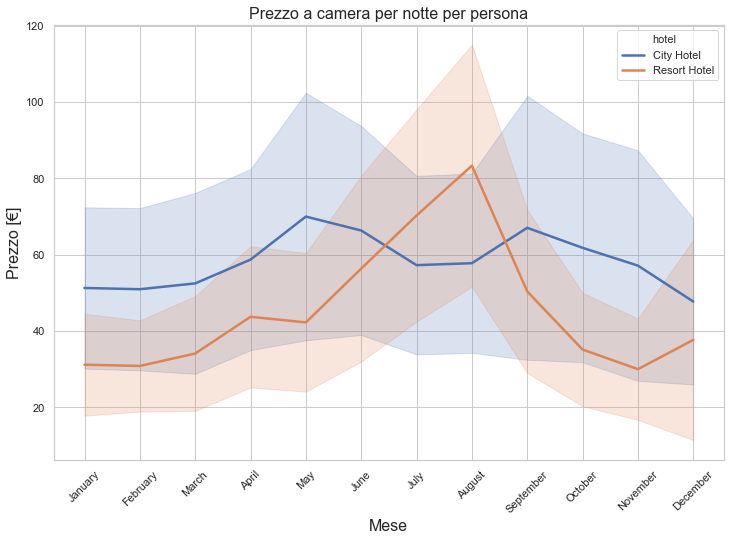

In [17]:
# grab data:
prezzo_camere_X_mese = set_intero_ospiti[["hotel", "arrival_date_month", "prezzo_X_persona"]].sort_values("arrival_date_month")

# order by month:
mesi_ordinati = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
prezzo_camere_X_mese["arrival_date_month"] = pd.Categorical(prezzo_camere_X_mese["arrival_date_month"], categories=mesi_ordinati, ordered=True)

# barplot with standard deviation:
plt.figure(figsize=(12, 8))
sns.lineplot(x = "arrival_date_month", y="prezzo_X_persona", hue="hotel", data=prezzo_camere_X_mese, 
            hue_order = ["City Hotel", "Resort Hotel"], ci="sd", size="hotel", sizes=(2.5, 2.5))
plt.title("Prezzo a camera per notte per persona", fontsize=16)
plt.xlabel("Mese", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Prezzo [€]", fontsize=16)
plt.show()

Come si poteva immaginare l'hotel in città ha un prezzo abbastanza stabile con i prezzi piu alti in primavera ed autunno.
Mentre il resort ha il picco in estate, risulta invece essere il piu economico durante il resto dell'anno

### Quali sono i mesi più "trafficati"?

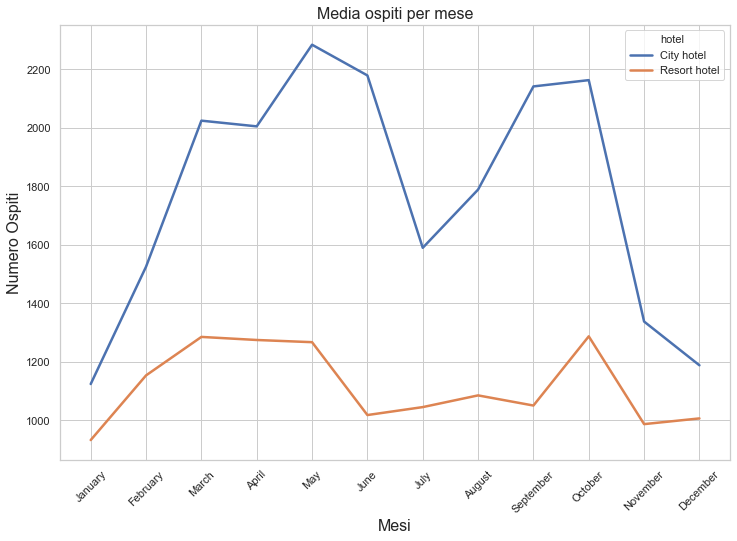

In [18]:
# Dividiamo i dataset:
resort_ospiti_X_mese = set_resort.groupby("arrival_date_month")["hotel"].count()
citta_ospiti_X_mese = set_citta.groupby("arrival_date_month")["hotel"].count()

resort_ospiti = pd.DataFrame({"month": list(resort_ospiti_X_mese.index),
                    "hotel": "Resort hotel", 
                    "guests": list(resort_ospiti_X_mese.values)})

citta_ospiti = pd.DataFrame({"month": list(citta_ospiti_X_mese.index),
                    "hotel": "City hotel", 
                    "guests": list(citta_ospiti_X_mese.values)})
intero_ospiti = pd.concat([resort_ospiti,citta_ospiti], ignore_index=True)


intero_ospiti["month"] = pd.Categorical(intero_ospiti["month"], categories=mesi_ordinati, ordered=True)

# Visto che i dati di luglio e agosto sono presenti per 3 anni mentre gli altri solo per due normalizziamo:
intero_ospiti.loc[(intero_ospiti["month"] == "July") | (intero_ospiti["month"] == "August"),
                    "guests"] /= 3
intero_ospiti.loc[~((intero_ospiti["month"] == "July") | (intero_ospiti["month"] == "August")),
                    "guests"] /= 2

#Mostra grafico:
plt.figure(figsize=(12, 8))
sns.lineplot(x = "month", y="guests", hue="hotel", data=intero_ospiti, 
             hue_order = ["City hotel", "Resort hotel"], size="hotel", sizes=(2.5, 2.5))
plt.title("Media ospiti per mese", fontsize=16)
plt.xlabel("Mesi", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Numero Ospiti", fontsize=16)
plt.show()

In Città ci sono piu ospiti durante la primavera e l'autunno, quando il prezzo è più alto.
Al contrario il resort ha meno ospiti quando il prezzo si alza.
Entrambe le struttura faticano in inverno.

### Quanto tempo restano gli ospiti?

In [19]:
# Modifichiamo i Dataset aggiungendo i dati rilevanti
set_resort["notti_totali"] = set_resort["stays_in_weekend_nights"] + set_resort["stays_in_week_nights"]
set_citta["notti_totali"] = set_citta["stays_in_weekend_nights"] + set_citta["stays_in_week_nights"]

numero_notti_resort = list(set_resort["notti_totali"].value_counts().index)
numero_prenotazioni_resort = list(set_resort["notti_totali"].value_counts())
numero_prenotazioni_resort = set_resort["notti_totali"].value_counts() / sum(numero_prenotazioni_resort) * 100 # in percentuale

numero_notti_citta = list(set_citta["notti_totali"].value_counts().index)
numero_prenotazioni_citta = list(set_citta["notti_totali"].value_counts())
numero_prenotazioni_citta = set_citta["notti_totali"].value_counts() / sum(numero_prenotazioni_citta) * 100 # in percentuale

notti_resort = pd.DataFrame({"hotel": "Resort hotel",
                           "numero_notti": numero_notti_resort,
                           "numero_prenotazioni": numero_prenotazioni_resort})

notti_citta = pd.DataFrame({"hotel": "City hotel",
                           "numero_notti": numero_notti_citta,
                           "numero_prenotazioni": numero_prenotazioni_citta})

notti_totali = pd.concat([notti_resort, notti_citta], ignore_index=True)

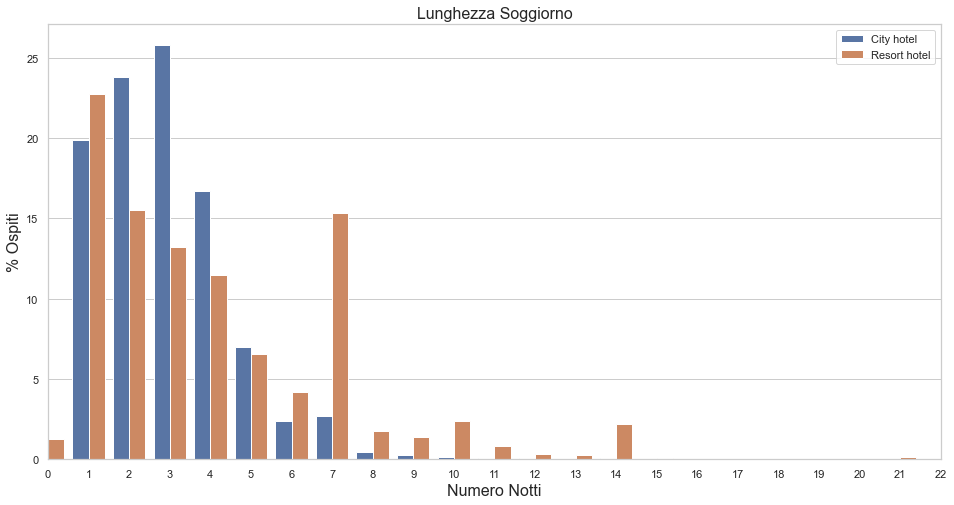

In [20]:
# Mettiamo il risultato in un grafico a barre:
plt.figure(figsize=(16, 8))
sns.barplot(x = "numero_notti", y = "numero_prenotazioni", hue="hotel", data=notti_totali,
            hue_order = ["City hotel", "Resort hotel"])
plt.title("Lunghezza Soggiorno", fontsize=16)
plt.xlabel("Numero Notti", fontsize=16)
plt.ylabel("% Ospiti", fontsize=16)
plt.legend(loc="upper right")
plt.xlim(0,22)
plt.show()

In [21]:
media_notti_resort = sum(list((notti_resort["numero_notti"] * (notti_resort["numero_prenotazioni"]/100)).values))
media_notti_citta = sum(list((notti_citta["numero_notti"] * (notti_citta["numero_prenotazioni"]/100)).values))
print(f"Un ospite in citta in media soggiorna per {media_notti_citta:.2f} notti, il soggiorno piu lungo è stato di {notti_citta['numero_notti'].max()} notti.")
print(f"Un ospite del resort in media soggiorna per {media_notti_resort:.2f} notti, il soggiorno piu lungo è stato di {notti_resort['numero_notti'].max()} notti.")

Un ospite in citta in media soggiorna per 2.92 notti, il soggiorno piu lungo è stato di 48 notti.
Un ospite del resort in media soggiorna per 4.14 notti, il soggiorno piu lungo è stato di 69 notti.


In città è evidente la preferenza per i ssoggiorni da 1 a 4 giorni  
Anche in citta c'è la preferenza per i ssoggiorni da 1 a 4 giorni, ma anche il pacchetto da 7 notti è molto popolare

### Prenotazioni per segmento di mercato

In [22]:
# Prenotazioni per segmento di mercato(consideriamo anche le cancellazioni)
segmenti_mercato=set_intero_pulito["market_segment"].value_counts()

# grafico a torta
fig = px.pie(segmenti_mercato,
             values=segmenti_mercato.values,
             names=segmenti_mercato.index,
             title="Prenotazioni per segmento di mercato",
             template="seaborn")
fig.update_traces(rotation=-90, textinfo="percent+label")
fig.show()

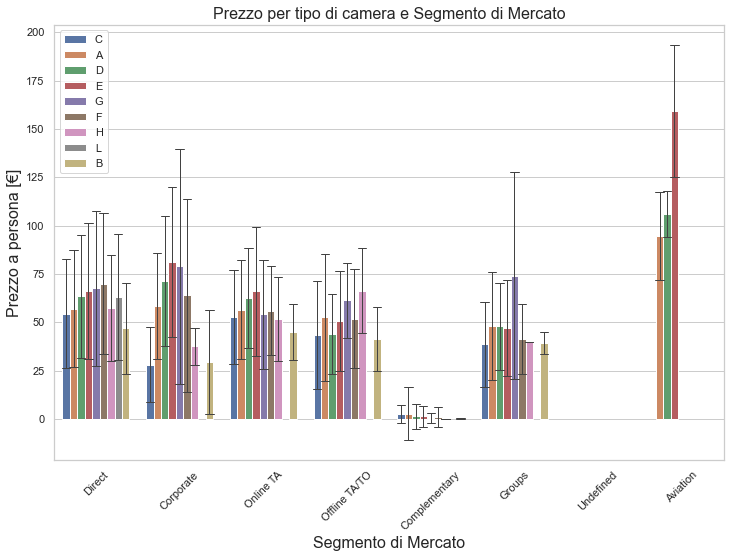

In [23]:
# prezzo per notte in base al tipo camera
# Mostra grafico
plt.figure(figsize=(12, 8))
sns.barplot(x="market_segment",
            y="prezzo_X_persona",
            hue="reserved_room_type",
            data=set_intero_pulito,
            ci="sd",
            errwidth=1,
            capsize=0.1)
plt.title("Prezzo per tipo di camera e Segmento di Mercato", fontsize=16)
plt.xlabel("Segmento di Mercato", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Prezzo a persona [€]", fontsize=16)
plt.legend(loc="upper left")
plt.show()

In media i gruppi ottengono il prezzo migliore, ma perchè le compagnie aeree pagano cosi tanto?  

In [24]:
# Modifichiamo i Dataset aggiungendo i dati rilevanti
compagnie_aeree = set_intero_pulito.loc[set_intero_pulito["market_segment"]== "Aviation"][["is_canceled",
                                                                                "adults",
                                                                                "lead_time",
                                                                                "prezzo_X_persona",]].describe()

non_compagnie_aeree = set_intero_pulito.loc[set_intero_pulito["market_segment"]!= "Aviation"][["is_canceled",
                                                                                    "adults",
                                                                                    "lead_time",
                                                                                    "prezzo_X_persona",]].describe()

In [25]:
compagnie_aeree.describe();

In [26]:
non_compagnie_aeree.describe();

- Le compagnie aeree prenotano molto a ridosso del soggiorno: in media 4 giorni, mentre per gli altri è quasi 4 mesi.
- Le compagnie hanno bisogno delle camere per ospitare gli equipaggi, non possono non prenderle.
- La maggior parte delle compagnie richiede camere singole per il personale

### Quante prenotazioni sono state cancellate?

In [27]:
# cancellazioni totali:
cancellazioni_totali = set_intero_pulito["is_canceled"].sum()
cancellazioni_resort = set_intero_pulito.loc[set_intero_pulito["hotel"] == "Resort Hotel"]["is_canceled"].sum()
cancellazioni_citta = set_intero_pulito.loc[set_intero_pulito["hotel"] == "City Hotel"]["is_canceled"].sum()

# in percentuale:
percentuale_cancellazioni_totali = cancellazioni_totali / set_intero_pulito.shape[0] * 100
percentuale_cancellazioni_resort = cancellazioni_resort / set_intero_pulito.loc[set_intero_pulito["hotel"] == "Resort Hotel"].shape[0] * 100
percentuale_cancellazioni_citta = cancellazioni_citta / set_intero_pulito.loc[set_intero_pulito["hotel"] == "City Hotel"].shape[0] * 100

print(f"Cancellazioni Totali: {cancellazioni_totali:,} ({percentuale_cancellazioni_totali:.0f} %)")
print(f"Cancellazioni Resort: {cancellazioni_resort:,} ({percentuale_cancellazioni_resort:.0f} %)")
print(f"Cancellazioni Citta: {cancellazioni_citta:,} ({percentuale_cancellazioni_citta:.0f} %)")

Cancellazioni Totali: 44,199 (37 %)
Cancellazioni Resort: 11,120 (28 %)
Cancellazioni Citta: 33,079 (42 %)


### In quali mesi ci sono piu cancellazioni?

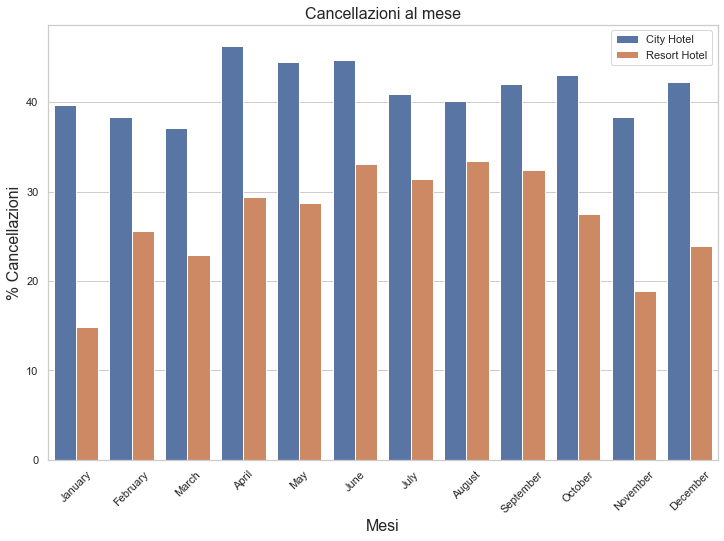

In [28]:
# Modifichiamo i Dataset aggiungendo i dati rilevanti
resort_prenotazioni_X_mese = set_intero_pulito.loc[(set_intero_pulito["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["hotel"].count()
resort_cancellazioni_X_mese = set_intero_pulito.loc[(set_intero_pulito["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

citta_prenotazioni_X_mese = set_intero_pulito.loc[(set_intero_pulito["hotel"] == "City Hotel")].groupby("arrival_date_month")["hotel"].count()
citta_cancellazioni_X_mese = set_intero_pulito.loc[(set_intero_pulito["hotel"] == "City Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

resort_cancellazioni = pd.DataFrame({"Hotel": "Resort Hotel",
                                "Mesi": list(resort_prenotazioni_X_mese.index),
                                "Prenotazioni": list(resort_prenotazioni_X_mese.values),
                                "Cancellazioni": list(resort_cancellazioni_X_mese.values)})
citta_cancellazioni = pd.DataFrame({"Hotel": "City Hotel",
                                "Mesi": list(citta_prenotazioni_X_mese.index),
                                "Prenotazioni": list(citta_prenotazioni_X_mese.values),
                                "Cancellazioni": list(citta_cancellazioni_X_mese.values)})

tutte_cancellazioni = pd.concat([resort_cancellazioni, citta_cancellazioni], ignore_index=True)
tutte_cancellazioni["percentuale_cancellazioni"] = tutte_cancellazioni["Cancellazioni"] / tutte_cancellazioni["Prenotazioni"] * 100

tutte_cancellazioni["Mesi"] = pd.Categorical(tutte_cancellazioni["Mesi"], categories=mesi_ordinati, ordered=True)

# Mostra grafico:
plt.figure(figsize=(12, 8))
sns.barplot(x = "Mesi", y = "percentuale_cancellazioni" , hue="Hotel",
            hue_order = ["City Hotel", "Resort Hotel"], data=tutte_cancellazioni)
plt.title("Cancellazioni al mese", fontsize=16)
plt.xlabel("Mesi", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("% Cancellazioni", fontsize=16)
plt.legend(loc="upper right")
plt.show()

In città abbiamo una media di cancellazioni stabile sul 40%.
Il resort ha un tasso di cancellazione più alto in estate e piu basso in inverno.

## 2. Predirre le Cancellazioni

Il nostro obiettivo è prevedere le cancellazioni, ma quali sono i fattori piu rilev

In [29]:
correlazione_cancellazioni = set_intero.corr()["is_canceled"]
correlazione_cancellazioni.abs().sort_values(ascending=False)[1:]

lead_time                         0.293123
total_of_special_requests         0.234658
required_car_parking_spaces       0.195498
booking_changes                   0.144381
previous_cancellations            0.110133
is_repeated_guest                 0.084793
agent                             0.083114
adults                            0.060017
previous_bookings_not_canceled    0.057358
days_in_waiting_list              0.054186
adr                               0.047557
babies                            0.032491
stays_in_week_nights              0.024765
company                           0.020642
arrival_date_year                 0.016660
arrival_date_week_number          0.008148
arrival_date_day_of_month         0.006130
children                          0.005048
stays_in_weekend_nights           0.001791
Name: is_canceled, dtype: float64

Sembra che i principali fattori correlati alla cancellazione siano lead_time, total_of_special_requests,required_car_parking_spaces, previous_cancellations.

Non abbiamo dimenticato booking_changes, proviamo a pensare alle tempistiche, al momento della prenotazione vogliamo prevedere se verrà cancellata oppure no, al momento della prenotazione non possiamo sapere quanti cambiamenti subirà, quindi non possiamo usarla nel nostro modello.




In [30]:
set_intero.groupby("is_canceled")["reservation_status"].value_counts()

is_canceled  reservation_status
0            Check-Out             75166
1            Canceled              43017
             No-Show                1207
Name: reservation_status, dtype: int64

Un altro punto di attenzione è reservation_status, puo essere equiparato a is_canceled, in nostro obiettivo, non puo essere un nostro parametro

In [31]:
### Quale Modello di ML scegliere

In [32]:
# Come abbiamo detto detto non includiamo is_canceled nelle nostre caratteristiche perche è il nostro obiettivo
# Altre possiamo escluderle per rendere il modello generico:
#     - arrival_date_year -> Giorno e mese da sole permettono di generalizzare sui vari periodi/stagioni, includere l'anno non permetterebbe di generalizzare
#     - assigned_room_type -> Non possiamo sapere al momento della prenotazione quale sarà l'effettiva tipologia di camera che sarà assegnata all'ospite
#     - booking_changes -> Anche qui, non possiamo sapere in anticipo quanti cambiamenti ci saranno
#     - reservation_status -> E' equiparabile al nostro obiettivo
#     - country -> In altre circostanze potrebbe essere utile, ma includerlo per prevedere le cancellazioni ridurrebbe la generalizzazione
#     - days_in_waiting_list -> Non disponibile al momento dellla prenotazione


# Caratteristiche numeriche
car_numeriche = ["lead_time","arrival_date_week_number","arrival_date_day_of_month",
                "stays_in_weekend_nights","stays_in_week_nights","adults","children",
                "babies","is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled","agent","company",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]

# Caratteristiche categoriche
car_categorie = ["hotel","arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"]

# Separiamo le caratteristiche e gli obiettivi
caratteristiche = car_numeriche + car_categorie
set_caratteristiche = set_intero.drop(["is_canceled"], axis=1)[caratteristiche] # Togliamo is_canceled e teniamo le caratteristiche desiderate
set_obiettivo = set_intero["is_canceled"] # teniamo solo il nostro obiettibo

# Prima di procedere puliamo i dati(come abbiamo visto nella parte di analisi):
# Per le caratteristiche numeriche usiamo il valore di Default 0.


trans_numeriche = Pipeline(steps=[
    ("scale", StandardScaler()),
    ("impute", SimpleImputer(strategy="constant", fill_value=0)),
    ])

# Per le categoriche, visto che parliamo di stringe useremo il valore di default "Unknown" :
trans_categorie = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown='ignore')),
    ])

# Applichiamo le modifiche:
preprocessor = ColumnTransformer(transformers=[("num", trans_numeriche, car_numeriche),
                                               ("cat", trans_categorie, car_categorie)])


In [33]:
# per la maggior parte dei progetti di Machine Learnig non avremo bisogno di creare un algoritmo da zero, basta trovare quello che meglio si addice ai nostri dati
# per farlo abbiamo due possibilità:
#    - Siamo, o abbiamo a disposizione un esperto del settore che stiamo studiando
#    - Verifichiamo le performance dei principali algoritmi di classificazione e/o regressione esistenti

modelli_base = [
                ("Perceptron",Perceptron(max_iter=40, tol=0.001, eta0=0.01, random_state=42)),
                ("Decision Tree", DecisionTreeClassifier(random_state=42)),
                ("Random Forest", RandomForestClassifier(random_state=42,n_jobs=-1)),
                ("Logistic Regression", LogisticRegression(random_state=42,n_jobs=-1)),
                #("KNeighborsClassifier",KNeighborsClassifier()),
                #("MLPClassifier", MLPClassifier(hidden_layer_sizes=[20,20], max_iter=200, tol=0.000001)) # Commentate questa riga se vi fidate dei risultati, l'ho inserita per fare un esempio di rete neurale ma un setup del genere è oneroso ed il suo risultato è intorno all'82%
               ]


# dividiamo il Dataset in modo da avere un insieme di dati per l'addestramento ed uno per la validazione
# 70% addestramento 30% validazione
split = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)

# Preprocessing, fitting, making predictions and scoring for every model:
for nome, modello in modelli_base:
    # pack preprocessing of data and the model in a pipeline:
    modello_corrente = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', modello)])
    
    
    
    risultato = cross_val_score(modello_corrente, 
                                 set_caratteristiche, set_obiettivo, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)
    # output:
    peggiore = round(min(risultato), 4)*100
    migliore = round(max(risultato), 4)*100
    medio = round(np.mean(risultato), 4)*100
    deviazione = round(np.std(risultato), 4)*100
    print(f"Punteggio medio per {nome}: {medio:.2f}% +/- {deviazione:.2f}% peggiore: {peggiore:.2f}%, migliore: {migliore:.2f}%")
    
    
    
    

    

Punteggio medio per Perceptron: 71.97% +/- 1.56% peggiore: 69.55%, migliore: 73.93%
Punteggio medio per Decision Tree: 82.32% +/- 0.21% peggiore: 82.08%, migliore: 82.63%
Punteggio medio per Random Forest: 86.62% +/- 0.20% peggiore: 86.35%, migliore: 86.94%
Punteggio medio per Logistic Regression: 81.02% +/- 0.12% peggiore: 80.89%, migliore: 81.21%


Il migliore dei 6 con più l'86.62% di risposte corrette è la Random Forest.

In [34]:
# Vediamo se possiamo migliorare un po il risultato ora che abbiamo deciso quale algoritmo usare.

random_forest = RandomForestClassifier(n_estimators=160,
                               max_features=0.4,
                               min_samples_split=2,
                               n_jobs=-1,
                               random_state=0)

modello_migliore = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', random_forest)])
risultato_migliore = cross_val_score(modello_migliore, 
                                 set_caratteristiche, set_obiettivo, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)
# output:
peggiore = round(min(risultato_migliore), 4)*100
migliore = round(max(risultato_migliore), 4)*100
medio = round(np.mean(risultato_migliore), 4)*100
deviazione = round(np.std(risultato_migliore), 4)*100
print(f"Punteggio migliorato: {medio:.2f}% +/- {deviazione:.2f}% peggiore: {peggiore:.2f}%, migliore: {migliore:.2f}%")

Punteggio migliorato: 86.75% +/- 0.18% peggiore: 86.44%, migliore: 87.00%


In [35]:
# Migliora, ma non di molto, 86.75%... Per ora va bene cosi

modello_migliore.fit(set_caratteristiche, set_obiettivo)
# Salviamo il modello sul disco
joblib.dump(modello_migliore, '../Trained-Models/cancellazioni.pkl')

['../Trained-Models/cancellazioni.pkl']